## Muon Deep Clustering Space Analysis

The DEC clustering library uses autoencoders to project the muon images into a feature space. Then a clustering algorithm is run on this feature space to try and group subjects with similar features. This document aims to look at how the muons are grouped using this algorithm, and whether the location of subjects relative to their assigned cluster center is meaningful.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from muon.deep_clustering.clustering import Config, Cluster
from muon.utils.subjects import Subjects

import os
import pickle
import math
import logging
import numpy as np
logger = logging.getLogger(__name__)

config = 'mnt/dec/dec_50_clusters/config_jupyter.json'
config = Config.load(config)
print(config.__dict__)
subjects = pickle.load(open(config.subjects, 'rb'))
cluster = Cluster.create(subjects, config)

logger.info('Training model')
cluster.train()
pred = cluster.predictions
logger.info('Done training network')


20171208_10:21:55 INFO Initialized logging


/home/michael/Documents/Zooniverse/repos/swap/conf
/home/michael/Documents/Zooniverse/repos/swap/conf/swap.conf


Using TensorFlow backend.


{'momentum': 0.9, 'ae_weights': 'mnt/dec/dec_output/ae_weights.h5', 'n_clusters': 50, 'batch_size': 256, 'tol': 0.001, 'nodes': [500, 500, 2000, 10], 'subjects': 'mnt/dec/dec_output/subjects.pkl', 'maxiter': 20000.0, 'update_interval': 140, 'lr': 0.01, 'save_dir': 'mnt/dec/dec_50_clusters'}


20171208_10:23:24 INFO Training model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 499)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               250000    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 50)                500       
Total params: 1,523,010
Trainable params: 1,523,010
Non-trainable params: 0
_________________________________________________________________


20171208_10:23:32 INFO Done training network


The table below shows the clusters used for this experiment, as well as the number of subjects assigned to each cluster, the swap label of the majority of subjects in the cluster, and the purity of this label among subjects in the cluster.

In [2]:
cluster.predictions.cluster_mapping

,n_assigned,majority_class,majority_class_fraction
0,395,0,0.994937
1,94,1,0.617021
2,379,0,0.978892
3,412,0,0.978155
4,236,0,0.991525
5,351,0,1.000000
6,217,0,0.944700
7,341,0,0.950147
8,304,0,0.990132
9,339,0,0.985251


Looking at just the clusters where the majority of subjects are real, we see that the proportion of real subjects in the cluster is rather low.

In [5]:
cm = cluster.predictions.cluster_mapping
indexes = np.where(np.array(cm['majority_class']) == 1)[0]
cm.loc[indexes]

,n_assigned,majority_class,majority_class_fraction
1,94,1,0.617021
13,90,1,0.588889
17,83,1,0.578313
32,82,1,0.585366
42,115,1,0.608696
47,58,1,0.620690


In the following plots, the subjects are sorted by their distance from the cluster center. For each cluster, we see  how the accuracy of the clusters change as we include subjects further away from the cluster center. We also see how the accuracy of a cluster changes as the distance from the cluster center varies.

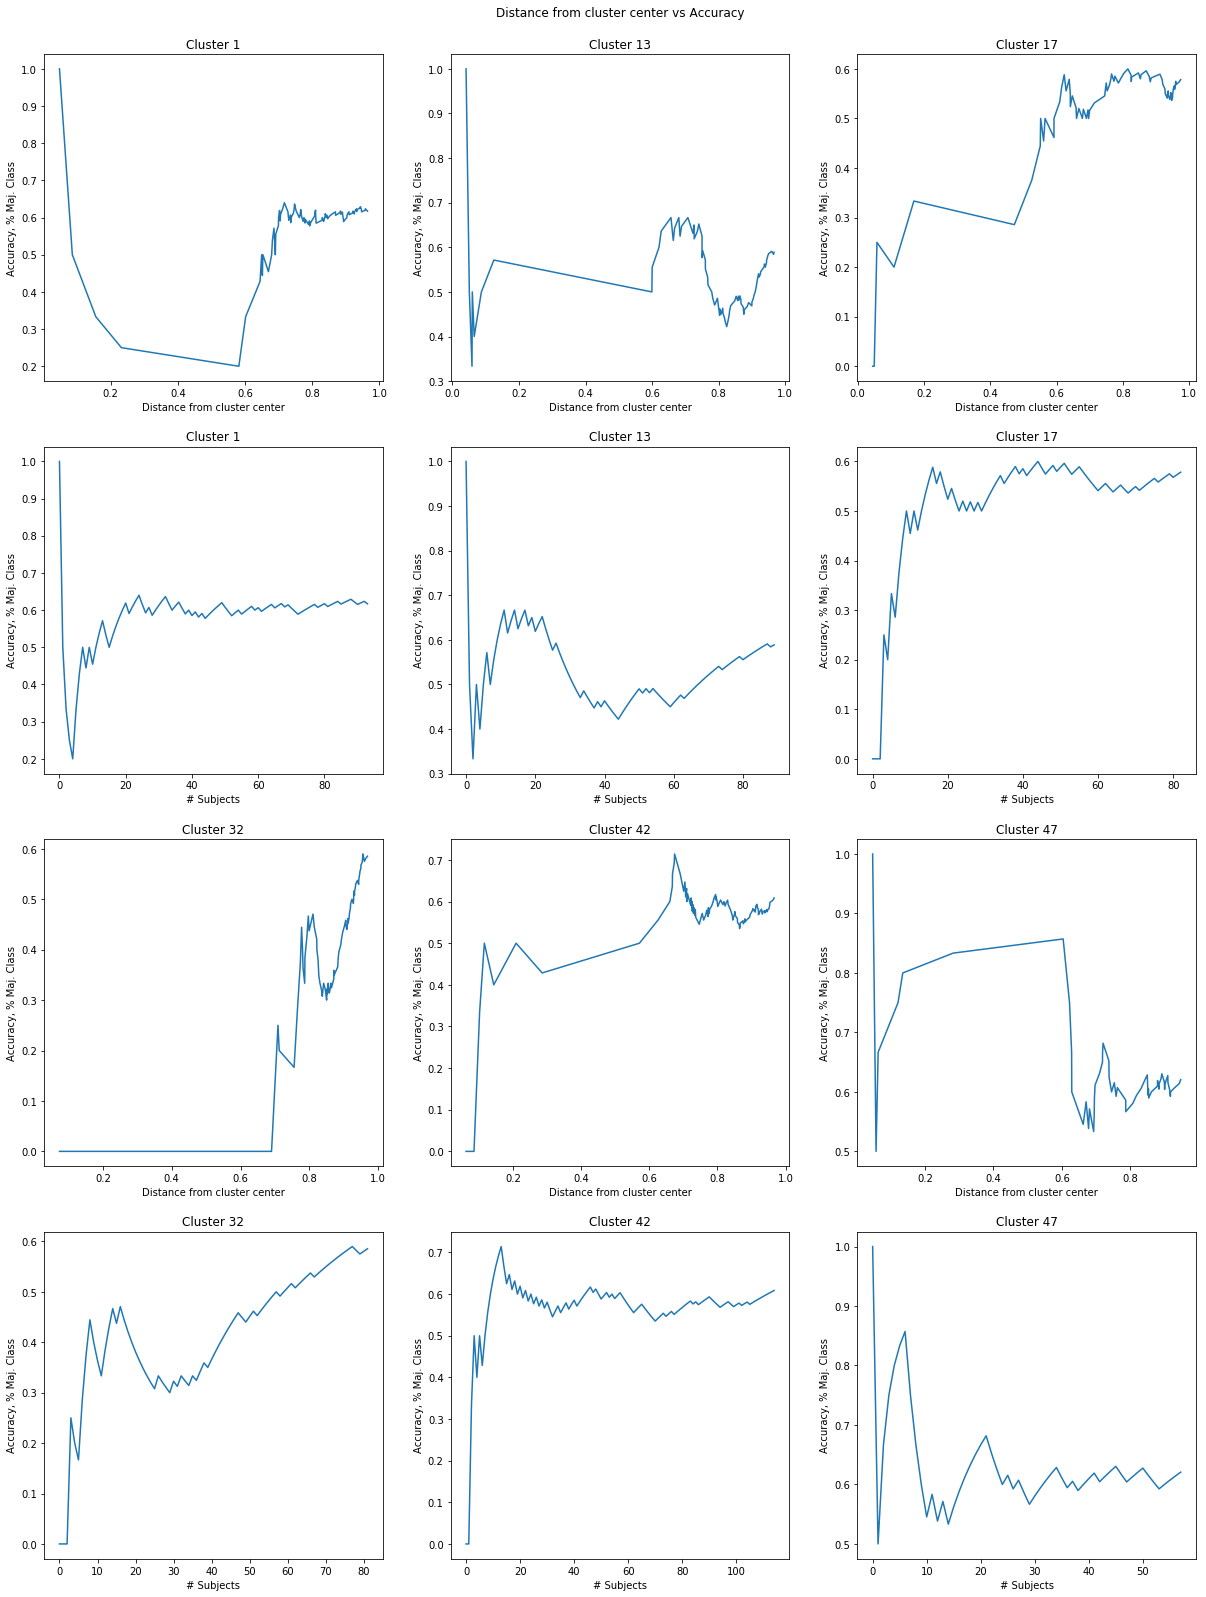

In [18]:
fig = plt.figure(figsize=(16, 22))
fig.subplots_adjust(left=0, right=1, bottom=0, top=.95, hspace=.2,
                    wspace=.2)


cm = cluster.predictions.cluster_mapping
clusters = np.where(cm['majority_class']==1)[0]
w = min(3, len(clusters))
l = math.ceil(len(clusters) / w)
for i, c in enumerate(clusters):
    i = math.floor(i/w) * w + i + 1
    ax = fig.add_subplot(2*l, w, i)
    ax.set_xlabel('Distance from cluster center')
    ax.set_ylabel('Accuracy, % Maj. Class')
    ax.set_title('Cluster %d' % c)
    cluster.feature_space.plot_acc(c, ax, 'distance')
    
    ax = fig.add_subplot(2*l, w, i + w)
    ax.set_xlabel('# Subjects')
    ax.set_ylabel('Accuracy, % Maj. Class')
    ax.set_title('Cluster %d' % c)
    cluster.feature_space.plot_acc(c, ax)
    
fig.suptitle('Distance from cluster center vs Accuracy')
    
plt.show()